In [1]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import scipy.sparse
import scanpy.external as sce
import sklearn.manifold
import statsmodels.api as sm

# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pyclustering.cluster.kmedoids import kmedoids

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# import seaborn as sb

import scanpy as sc
import harmonypy as hm
import anndata
import pickle
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
from scipy.stats import chi2_contingency
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 
import os
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3

In [2]:
#import scrublet as scr
import numpy as np
import pandas as pd
import statistics as st
import re
import csv
import scanpy as sc 
import scanpy.external as sce
import phate
import matplotlib
from matplotlib import pyplot as plt
import warnings
from scipy.stats import binom
from scipy.stats import multinomial
import seaborn
from scipy.stats import hypergeom
import warnings
warnings.filterwarnings('ignore')
import scrublet as scr
import harmonypy as hm
from random import sample
from _util_updated import cluster_bias

### Load Data

In [3]:
SC_DF = sc.read_h5ad('./Knockout_CM_DF.h5ad')

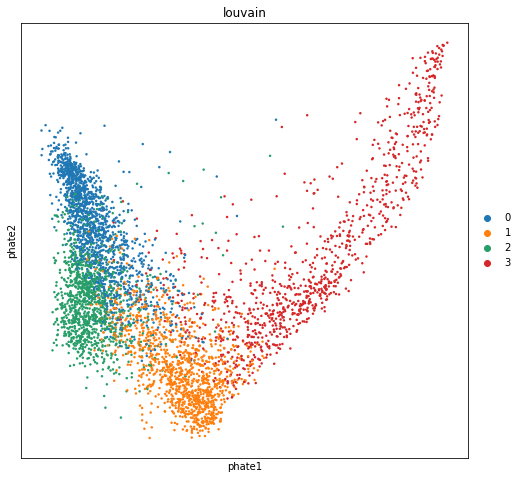

In [34]:
sce.pl.phate(SC_DF, color = 'louvain')

In [43]:
temp = SC_DF[SC_DF.obs.Sample == 'WT']
total_nc = temp.shape[0]
vent_nc = temp[temp.obs.louvain == '0'].shape[0]
nc_perc = vent_nc/total_nc

temp = SC_DF[SC_DF.obs.Sample != 'WT']
total_pert = temp.shape[0]
vent_pert = temp[temp.obs.louvain == '0'].shape[0]
pert_perc = vent_pert/total_pert

In [46]:
nc_perc/pert_perc

7.321862603678326

### Cluster Bias (Combined Biological Reps)

In [5]:
control_cells = SC_DF[SC_DF.obs.Sample == 'WT'].obs.index.tolist()

In [6]:
Enr_List = []
Depleted_List = []
Target_List = []

for sample in SC_DF.obs.Sample.cat.categories.tolist():
    if sample == 'WT':
        continue
    Target_List.append(sample)
    target_cells = SC_DF[SC_DF.obs.Sample == sample].obs.index.tolist()
    
    depleted_pvals, depleted_list = cluster_bias(target_cells,control_cells, SC_DF, direction='depletion')
    enriched_pvals, enriched_list = cluster_bias(target_cells,control_cells, SC_DF, direction='enrichment')
    
    Enr_List.append(enriched_pvals)
    Depleted_List.append(depleted_pvals)

In [7]:
Enr_DF = pd.DataFrame(data=Enr_List, columns=SC_DF.obs.louvain.cat.categories.tolist(), index = Target_List)
Dep_DF = pd.DataFrame(data=Depleted_List, columns=SC_DF.obs.louvain.cat.categories.tolist(), index = Target_List)

### Bar Graph Distribution

In [8]:
cluster_list = ['3', '1', '2', '0']

In [9]:
Total_Percents = []
Targets = []
for target in SC_DF.obs.Sample.cat.categories:
    Targets.append(target)
    
    target_sc = SC_DF[SC_DF.obs['Sample'] == target]
    target_cells = target_sc.shape[0]
    target_percents = []
    
    for cluster in cluster_list:
        target_percents.append((target_sc[target_sc.obs.louvain == cluster].shape[0]/target_cells)*100)
        
    Total_Percents.append(target_percents)

In [10]:
ENH3_cmap = {
    'Early_CM': '#dd8452',
    'Mid_CM': '#dd8452',
    'Late_CM_KO': '#dd8452',
    'Late_CM_WT' : '#dd8452'}

In [11]:
ENH5_cmap = {
    'Early_CM': '#C4B04F',
    'Mid_CM': '#C4B04F',
    'Late_CM_KO' : '#C4B04F',
    'Late_CM_WT' : '#C4B04F'}

In [12]:
WT_cmap = {
    'Early_CM': '#8c8c8c',
    'Mid_CM': '#8c8c8c',
    'Late_CM_KO' : '#8c8c8c',
    'Late_CM_WT' : '#8c8c8c'}

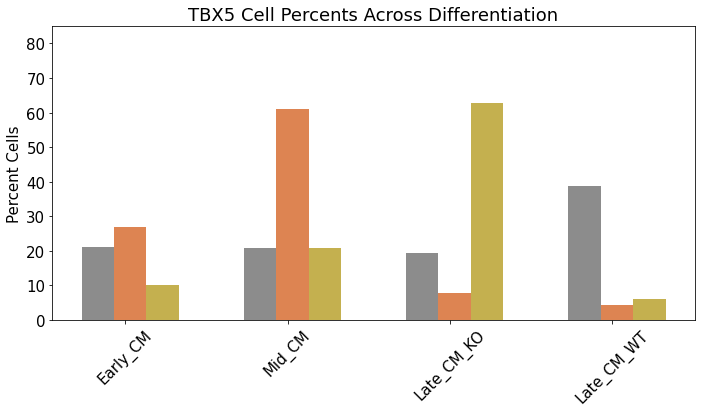

In [14]:
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(1, figsize=(10,6))

width = 0.20

labels =  ['Early_CM', 'Mid_CM', 'Late_CM_KO', 'Late_CM_WT' ]


for i, c in enumerate(Total_Percents[2]):
    ax.bar(i, c, width, color=WT_cmap[labels[i]])
    
for i, c in enumerate(Total_Percents[0]):
    ax.bar(i + width, c, width, color=ENH3_cmap[labels[i]])

for i, c in enumerate(Total_Percents[1]):
    ax.bar(i + width + width, c, width, color=ENH5_cmap[labels[i]])
    
ax.set_xticks(np.arange(i+1) + .17)
ax.set_xticklabels(labels)
ax.set_ylabel('% Cells')
plt.xticks(rotation = 45)
rects = ax.patches
rect_subset = rects[4:]



plt.ylim(0, 85)
plt.ylabel('Percent Cells')
plt.title('TBX5 Cell Percents Across Differentiation')
fig.tight_layout()
fig.savefig('./CM_PHATE_Bar.pdf')